In [1]:
# The MIT License (MIT)

# Copyright (c) 2020 NVIDIA CORPORATION.

# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# ignore this (just for development)
import sys
sys.path.append("..")

In [2]:
import cuAugment

In [3]:
dir(cuAugment)

['Augmenter',
 'Timer',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'augmenter',
 'cuAugment',
 'distributions',
 'templates',
 'timer',
 'transformations']

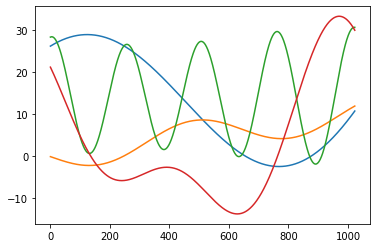

In [4]:
import numpy as np
import pylab as pl

num_samples, batch_size = 1024, 4

T = np.expand_dims(np.linspace(0, 1, num_samples)*np.ones((batch_size, 1)), 2)
W = np.random.normal(0, 10, (3, 2, batch_size, 1, 1))
X_cpu = W[0,0]*np.cos(W[0, 1]*T)+ W[1,0]*np.sin(W[1, 1]*T)+W[2,0]*T+W[2,1]

for series in X_cpu:
    pl.plot(series.flatten())

In [5]:
from numba import cuda

# output batch of the saḿe batch_size and double resolution in channels_last order
Y_cpu = np.empty((  X_cpu.shape[0], 
                  2*X_cpu.shape[1], 
                    X_cpu.shape[2]), dtype=X_cpu.dtype)

# let us work exclusively on the GPU
X = cuda.to_device(X_cpu)
Y = cuda.to_device(Y_cpu)

print("shape of X", X.shape)
print("shape of Y", Y.shape)

shape of X (4, 1024, 1)
shape of Y (4, 2048, 1)


In [6]:
# define the augmentor in 2D, 
# channels_last as input and channels_last as output format

from cuAugment.transformations import *
from cuAugment.distributions import *

jitaug = cuAugment.Augmenter(dim=1, channel_mode='CL2CL')

# change [0, 1] coordinates to [-1, +1] 
jitaug.add_spatial_op(CenterX())

# add a random rotation, flips, translations
jitaug.add_spatial_op(DeformX(UniformDistribution(-0.5, 0.5))) 
jitaug.add_spatial_op(LinearX(UniformDistribution(1.5, 2.0))) 
jitaug.add_spatial_op(FlipX(BernoulliDistribution(0.5)))
jitaug.add_spatial_op(TranslateX(UniformDistribution(-0.3, 0.3)))

# go back to [0, 1] coordinates
jitaug.add_spatial_op(UncenterX())

# add a few color space augmentations
jitaug.add_color_op(ScaleColor(UniformDistribution(lower=0.5, upper=1.0)))
jitaug.add_color_op(InvertColor(BernoulliDistribution(0.5)))

# now compile the source code
jitaug.compile(verbose=True)

STATUS: augmentor code generated in module_1301521788909709700.py


In [7]:
# excecute the augmentation a few times
# (first run slower due to JIT overhead)

num_repeats = 4  # set > 1 to measure without jit overhead
seed = 3070      # seed = None results in random seeds each augmentation
verbose = True   # provide additional info if input batch_size != output batch_size

# define the value per color channel if interpolation exceeds input domain
empty_values = np.array([0])

# repeat augmentation a few times
for _ in range(num_repeats):
    with cuAugment.Timer('augmentation'):
        Y = jitaug(X, Y, empty_values=empty_values, seed=seed, verbose=verbose)  

# for troughput computation
from functools import reduce
print("STATUS: processed", 4*(reduce(lambda x, y: x*y, X.shape, 1)+ \
                              reduce(lambda x, y: x*y, Y.shape, 1)), "B")

STATUS: elapsed time 585 ms (augmentation)
STATUS: elapsed time 3 ms (augmentation)
STATUS: elapsed time 3 ms (augmentation)
STATUS: elapsed time 3 ms (augmentation)
STATUS: processed 49152 B


In [8]:
with cuAugment.Timer("copy result to CPU"):
    Y_cpu = Y.copy_to_host()

STATUS: elapsed time 0 ms (copy result to CPU)


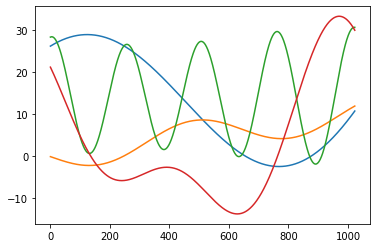

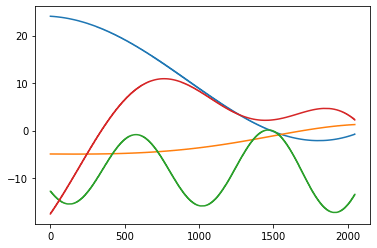

In [9]:
# plot 1D time series in input batch
for series in X_cpu:
    pl.plot(series)
pl.show()

# plot 1D time series in output batch
for series in Y_cpu:
    pl.plot(series)
pl.show()

In [10]:
# inspect the generated source code
print(jitaug.string)


# Copyright (c) 2020, NVIDIA CORPORATION.

# NOTE: this file was generated by a machine 

from numba import cuda
import math

@cuda.jit
def augment(batch_in, batch_out, empty_values, spatial_params1, spatial_params2, spatial_params3, spatial_params4, color_params0, color_params1):
    """fused augmentation kernel for SOL tensor manipulation"""

    # fix the dimensions of the input tensor in "channels last" order
    dimB_in = 0
    dimC_in = 2
    dimX_in = 1

    # fix the dimensions of the output tensor in "channels last" order
    dimB_out = 0
    dimC_out = 2
    dimX_out = 1

    # set starting indices of grid-stride loops    
    lowerB = 0 
    lowerC = 0
    lowerX = cuda.blockIdx.x*cuda.blockDim.x+cuda.threadIdx.x
    
    # set strides of grid-stride loops
    strideB = 1 
    strideC = 1
    strideX = cuda.blockDim.x*cuda.gridDim.x

    # 2+1 nested grid-stride loops follow (ignore strange indentation)
    # for all batch indices in the output tensor    
    for b_out in r